In [22]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py
import copy
import pickle
%matplotlib inline

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from data_preprocessing.preprocessing import create_bins, get_firing_rate, convert_gaze_coordinates, cut_excess_timepoints, append_fixations, movie_paths, get_video_duration_fps

In [ ]:
def cutt_short_movies(paths, neural_dict, gaze_dict, len_avg_window, foreperiod_len):
    stimuli_names = list(neural_dict.keys())
    movies_folder = movie_paths(paths, stimuli_names)
    foreperiod_len_timepts = round(foreperiod_len / len_avg_window)
    for fn in stimuli_names:
        if neural_dict[fn].size: 
            fps, vid_duration = get_video_duration_fps(f"{movies_folder}/{fn}")
            vid_duration = round(vid_duration / len_avg_window)
            if vid_duration + foreperiod_len_timepts< neural_dict[fn].shape[1]:
                neural_dict[fn] = neural_dict[fn][:,:vid_duration + foreperiod_len_timepts, :]
            if vid_duration + foreperiod_len_timepts < gaze_dict[fn].shape[1]:
                gaze_dict[fn] = gaze_dict[fn][:,:vid_duration + foreperiod_len_timepts, :]
    return neural_dict, gaze_dict



In [25]:
def append_fixationss(trial_gaze, trial_number, trials, len_avg_window, stim_onset_delay, foreperiod_len):
    gaze_len = trial_gaze.shape[1]
    fixation_times = trials[trial_number]["fixation_times"]
    fixation_times_delay = fixation_times[0].astype(int) - stim_onset_delay + foreperiod_len - 1 # -1 for python indexing, the other for the fact that we are subtracting 1 to stimulus_duration
    downsampled_fixation_times = np.round(fixation_times_delay/len_avg_window).astype(int)
    fixation_mask = (downsampled_fixation_times >= 0) & (downsampled_fixation_times <= gaze_len)
    fixation_masked = downsampled_fixation_times[np.any(fixation_mask, axis=1)]
    if fixation_masked.shape[0]!=0:
        if fixation_masked[0,0] < 0:
            fixation_masked[0,0] = 0
        if fixation_masked[-1, 1] >= gaze_len:
            fixation_masked[-1, 1] = gaze_len -1
    else:
        print_wise(f"Warning! - Trial {trial_number} doesn't have any fixation")
    fixation_binary = np.zeros(gaze_len)
    for onset, offset in fixation_masked:
        fixation_binary[onset:offset] = 1  
    trial_gaze_fixations = np.concatenate((trial_gaze, fixation_binary[np.newaxis,:]), axis=0)      
    return trial_gaze_fixations


In [51]:
def format_in_trials(paths, file_list, len_avg_window, foreperiod_len, rasters, trials, stimuli):
    unique_stimuli_names = set(file_list)
    final_res_neural = {name : [] for name in unique_stimuli_names}
    final_res_gaze = copy.deepcopy(final_res_neural)

    # correctly estimates trials durations
    for idx, fn in enumerate(file_list):  # range(len(stimuli)): 
        trial_number = (int(stimuli[idx]["trial_number"][0].item()) - 1)  # extracts the trial number to which the stimulus corresponds (-1 because of python indexing)
        
        if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
            trial_start = stimuli[idx]["start_time"][0].item()
            trial_end = stimuli[idx]["stop_time"][0].item()
            trial_duration = trial_end - trial_start
            stim_onset_delay = trial_start - trials[trial_number]["start_time"][0].item()
            stim_onset_delay = round(stim_onset_delay) - 1  # -1 for python indexing
            gaze_signal = trials[trial_number]["eye_data"][0]
            end_gaze = stim_onset_delay + round(trial_duration) # min(stim_onset_delay + round(trial_duration), len(gaze_signal))
            gaze_signal = gaze_signal[stim_onset_delay - foreperiod_len :end_gaze, :].T # extracts gaze from the stimulus onset till the end of the trial
            trial_start_int = round(trial_start)
            trial_end_int = round(trial_end)
            bins = create_bins(trial_duration + foreperiod_len, len_avg_window)
            neural_signal = rasters[trial_start_int - foreperiod_len:trial_end_int, :].T  # slices the trial from raster
            trial_firing_rate = get_firing_rate(bins, neural_signal)
            trial_gaze = get_firing_rate(bins, gaze_signal)
            trial_gaze = convert_gaze_coordinates(trial_gaze)
            trial_gaze = append_fixationss(trial_gaze, trial_number, trials, len_avg_window, stim_onset_delay, foreperiod_len) # here
            final_res_neural[fn].append(trial_firing_rate)
            final_res_gaze[fn].append(trial_gaze)
        # if trials[trial_number]["success"] == 1 and stimuli[idx]["filename"] == fn:
    # end for i in range(len(stimuli)):
    final_res_neural = cut_excess_timepoints(final_res_neural)
    final_res_gaze = cut_excess_timepoints(final_res_gaze)
    final_res_neural, final_res_gaze = cutt_short_movies(paths, final_res_neural, final_res_gaze, len_avg_window, foreperiod_len) # here
    return final_res_neural, final_res_gaze



In [3]:
day = "0825"
rasters_path = f"/Volumes/LivingstoneLab/Data/Data-Formatted/red_2025{day}-rasters.h5"
exp_path = f"/Volumes/LivingstoneLab/Data/Data-Formatted/red_2025{day}_experiment.mat"

In [9]:
with h5py.File(rasters_path, "r") as f:
    rasters = f["rasters"][:]
d = loadmat(exp_path)
trials = d["Trials"]
stimuli = d["Stimuli"]


In [14]:
s = np.concatenate(stimuli["filename"])
# file_list = [str(x[0]) for x in s]


In [52]:
resolution_Hz = 100
foreperiod_len = 300
s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]
len_window_firing_rate = 1000/resolution_Hz
neural, gaze = format_in_trials(paths, file_list, len_window_firing_rate, foreperiod_len, rasters, trials, stimuli)

09:25:55 - Warning! IMG_4660.mp4 has different time-points across trials [1030, 1032, 1034]
09:25:55 - Warning! IMG_4658.mp4 has different time-points across trials [1034, 1032]
09:25:55 - Warning! IMG_4661.mp4 has different time-points across trials [1034, 1034, 1032]
09:25:55 - Warning! IMG_4668.mp4 has different time-points across trials [1032, 1034, 1032, 1032, 1032, 1032, 1034]
09:25:55 - Warning! IMG_4656.mp4 has different time-points across trials [1034, 1032]
09:25:55 - Warning! IMG_4663.mp4 has different time-points across trials [1032, 1034, 1032, 1032, 1034]
09:25:55 - Warning! IMG_4666.mp4 has different time-points across trials [1032, 1031]
09:25:55 - Warning! IMG_4659.mp4 has different time-points across trials [1034, 1032, 1032, 1034, 1031, 1032, 1031, 1032, 1032]
09:25:55 - Warning! IMG_4670.mp4 has different time-points across trials [1034, 1030, 1032, 1031, 1032, 1032, 1032, 1034, 1031]
09:25:55 - Warning! IMG_4672.mp4 has different time-points across trials [1034, 10

In [53]:
import cv2
fn = "IMG_4658.mp4"
movies_folder = movie_paths(paths, list(neural.keys()))
video_path = f"{movies_folder}/{fn}"
cap = cv2.VideoCapture(video_path)

In [54]:
video = []
counter = 0
while True:
    counter += 1
    ret, frame = cap.read()
    if not ret:
            print(f"breaking at {counter}")
            break
    frame = np.array(frame, dtype=np.uint8)  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.append(frame)

breaking at 329


In [ ]:
# REWRITE THE FUNCTIONS!

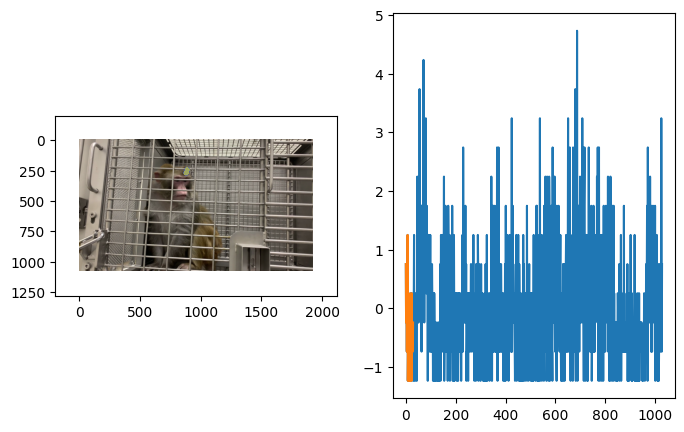

In [55]:
from scipy.stats import zscore
from IPython.display import clear_output
import matplotlib.pyplot as plt

eyes = gaze[fn][:,:,0]
neural_sign = zscore(np.mean(neural[fn][:,:,0], axis=0))

for i in range(0, eyes.shape[1], 3):
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))  # create a figure and axes
    if i > foreperiod_len /len_window_firing_rate:
        ax[0].imshow(video[int(i//3.3)])
    if i > 55:
        ax[0].plot(eyes[0, i-50:i], eyes[1, i-50:i], color='yellow', linewidth=3, alpha=0.5)
        sc = ax[0].scatter(
            eyes[0, i-50:i], eyes[1, i-50:i],
            c=eyes[2, i-50:i], cmap='coolwarm', s=10, edgecolors='none'
        )
    else:
        ax[0].plot(eyes[0, :i], eyes[1, :i], color='yellow', linewidth=3, alpha=0.5)
        sc = ax[0].scatter(
            eyes[0, :i], eyes[1, :i],
            c=eyes[2, :i], cmap='coolwarm', s=10, edgecolors='none'
        )

    ax[0].set_xlim(-200, 2120)
    ax[0].set_ylim(-200, 1280)
    ax[0].invert_yaxis()
    if i > 30:
        ax[1].plot(neural_sign[:i])
        ax[1].plot(neural_sign[:30])
    else:
        ax[1].plot(neural_sign[:i], color='red')
    
    plt.pause(0.01)
    plt.close(fig)  # now this works
    clear_output(wait=True)

In [18]:
pkl_path = "/Volumes/LivingstoneLab/tiziano/data/neural_red_250818_plx_60Hz.pkl"

with open(pkl_path, "rb") as f:
    neural_pkl = pickle.load(f)

print(type(neural_pkl))
# if isinstance(neural_pkl, dict):
#     print("keys:", list(neural_pkl.keys()))
# else:
#     try:
#         print("length:", len(neural_pkl))
#     except Exception:
#         pass

<class 'dict'>


In [17]:
for k in neural.keys():
    print(neural[k].shape)

(64, 601, 2)
(64, 601, 2)
(64, 601, 3)
(64, 601, 1)
(64, 601, 3)
(64, 601, 2)
(64, 603, 1)
(64, 600, 2)
(64, 600, 1)
(64, 601, 6)
(64, 601, 1)
(64, 600, 2)
(0,)
(64, 601, 4)
(0,)
(64, 601, 2)
(64, 600, 3)
(64, 601, 2)
(64, 601, 1)
(64, 601, 2)
(64, 600, 7)
(64, 603, 1)
(64, 600, 2)
(64, 600, 2)
